In [1]:
import pandas as pd
import numpy as np
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('clean_air.csv')

# Display the first few rows of the dataframe
data.head()


,City,Year,Month,Day,Seasonality,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,0,2015,1,1,0,82.6825,116.272721,0.92,18.22,17.15,23.483476,0.92,27.64,133.36,0.00,0.02,0.00,350.333333,0
1,0,2015,1,2,0,82.6825,116.272721,0.97,15.69,16.46,23.483476,0.97,24.55,34.06,3.68,5.50,3.77,350.333333,0
2,0,2015,1,3,0,82.6825,116.272721,17.40,19.30,29.70,23.483476,17.40,29.07,30.70,6.80,16.40,2.25,350.333333,0
3,0,2015,1,4,0,82.6825,116.272721,1.70,18.48,17.97,23.483476,1.70,18.59,36.08,4.43,10.14,1.00,350.333333,0
4,0,2015,1,5,0,82.6825,116.272721,22.10,21.42,37.76,23.483476,22.10,39.33,39.31,7.01,18.89,2.78,350.333333,0


In [2]:
# Check the unique values and their counts in the 'AQI_Bucket' column
aqi_bucket_counts = data['AQI_Bucket'].value_counts()

aqi_bucket_counts

AQI_Bucket
3    10914
4     8628
1     3043
0     2694
2     1457
5     1421
Name: count, dtype: int64

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('clean_air.csv')

# Assuming the target variable 'AQI_Bucket' is categorical and all other necessary preprocessing has been done

# Separate the features and the target
X = df.drop(['AQI', 'AQI_Bucket'], axis=1)  # Drop 'AQI' as per your request
y = df['AQI_Bucket']

# ANOVA F-test feature selection
selector = SelectKBest(f_classif, k='all')
X_new = selector.fit_transform(X, y)
df_scores = pd.DataFrame(selector.scores_, index=X.columns, columns=['F_Scores'])
df_pvalues = pd.DataFrame(selector.pvalues_, index=X.columns, columns=['P_Values'])

# Feature importance from a Random Forest Classifier with reduced number of trees
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X, y)
df_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

# Combine ANOVA F-test results with Random Forest feature importances
combined_features = df_scores.join(df_pvalues).join(df_importances)
combined_features = combined_features.sort_values(by='Importance', ascending=False)  # Sort by importance

# Scale features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)
pca_components = pd.DataFrame(pca.components_, columns=X.columns)

# Get the absolute correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_reduced = X.drop(df[to_drop], axis=1)

# Final DataFrame with selected features
final_features = combined_features.loc[X_reduced.columns]

# Print the final selected features
final_features


,F_Scores,P_Values,Importance
City,217.624651,1.335339e-228,0.025623
Year,511.830879,0.000000e+00,0.023576
Month,42.978322,2.743983e-44,0.018990
Day,2.667942,2.041514e-02,0.024578
Seasonality,233.274804,6.780665e-245,0.012019
PM2.5,6752.133070,0.000000e+00,0.256332
PM10,3652.051058,0.000000e+00,0.176499
NO,1018.362870,0.000000e+00,0.046487
NO2,1897.656065,0.000000e+00,0.046748
NOx,1210.943865,0.000000e+00,0.041208


In [4]:
sorted_features = combined_features.sort_values(by=['F_Scores', 'P_Values'], ascending=[False, True])

sorted_features

,F_Scores,P_Values,Importance
PM2.5,6752.133070,0.000000e+00,0.256332
PM10,3652.051058,0.000000e+00,0.176499
CO,2834.236856,0.000000e+00,0.104179
NO2,1897.656065,0.000000e+00,0.046748
NOx,1210.943865,0.000000e+00,0.041208
NO,1018.362870,0.000000e+00,0.046487
SO2,977.027603,0.000000e+00,0.045688
Year,511.830879,0.000000e+00,0.023576
O3,431.913901,0.000000e+00,0.053132
Toluene,412.606686,0.000000e+00,0.032857


In [5]:
# Random Forest Regressor 
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset
data_r = pd.read_csv('clean_air.csv')

# Preprocess the data
# Assuming the 'AQI' column is the one we want to predict
input_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2']
X_r = data_r[input_features]
y_r = data_r['AQI']

# Split the dataset into train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

# Optional: Scale the features
scaler = StandardScaler()
X_train_scaled_r = scaler.fit_transform(X_train_r)
X_test_scaled_r = scaler.transform(X_test_r)

# Train the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled_r, y_train_r)

# Predict on the training set
y_pred_train_r = rf_regressor.predict(X_train_scaled_r)

# Predict on the test set
y_pred_test_r = rf_regressor.predict(X_test_scaled_r)

# Evaluate the model using RMSE
rmse_train_r = np.sqrt(mean_squared_error(y_train_r, y_pred_train_r))
rmse_test_r = np.sqrt(mean_squared_error(y_test_r, y_pred_test_r))

print(f'Random Forest Regressor - Training RMSE: {rmse_train_r}')
print(f'Random Forest Regressor - Testing RMSE: {rmse_test_r}')


Random Forest Regressor - Training RMSE: 16.63022134558609
Random Forest Regressor - Testing RMSE: 49.51134020489731


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

# Function to calculate Adjusted R-squared
def adjusted_r_squared(r_squared, num_data_points, num_predictors):
    return 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_predictors - 1)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Metrics for the training set
mse_train = mean_squared_error(y_train_r, y_pred_train_r)
r2_train = r2_score(y_train_r, y_pred_train_r)
rmse_train = np.sqrt(mse_train)
adjusted_r2_train = adjusted_r_squared(r2_train, X_train_r.shape[0], X_train_r.shape[1])
mape_train = mean_absolute_percentage_error(y_train_r, y_pred_train_r)

# Metrics for the test set
mse_test = mean_squared_error(y_test_r, y_pred_test_r)
r2_test = r2_score(y_test_r, y_pred_test_r)
rmse_test = np.sqrt(mse_test)
adjusted_r2_test = adjusted_r_squared(r2_test, X_test_r.shape[0], X_test_r.shape[1])
mape_test = mean_absolute_percentage_error(y_test_r, y_pred_test_r)

# Printing out the metrics
print(f'Training Metrics:\nMSE: {mse_train}\nRMSE: {rmse_train}\nR-squared: {r2_train}\nAdjusted R-squared: {adjusted_r2_train}\nMAPE: {mape_train}\n')
print(f'Testing Metrics:\nMSE: {mse_test}\nRMSE: {rmse_test}\nR-squared: {r2_test}\nAdjusted R-squared: {adjusted_r2_test}\nMAPE: {mape_test}\n')

# Note: Accuracy and Confusion Matrix are not applicable for regression tasks.


Training Metrics:
MSE: 276.5642620031872
RMSE: 16.63022134558609
R-squared: 0.9853266606835044
Adjusted R-squared: 0.9853220990911423
MAPE: 5.380386610221447

Testing Metrics:
MSE: 2451.3728088850808
RMSE: 49.51134020489731
R-squared: 0.8729031390309749
Adjusted R-squared: 0.8727449459252169
MAPE: 14.925451991918584



In [7]:
def predict_aqi_bucket(pm25, pm10, no, no2, nox, co, so2, rf_regressor, scaler):
    # Create a DataFrame from the input features
    input_features = pd.DataFrame({
        'PM2.5': [pm25],
        'PM10': [pm10],
        'NO': [no],
        'NO2': [no2],
        'NOx': [nox],
        'CO': [co],
        'SO2': [so2]
    })

    # Scale the features using the previously fitted scaler
    input_features_scaled = scaler.transform(input_features)

    # Predict the AQI bucket
    aqi_bucket = rf_regressor.predict(input_features_scaled)

    return aqi_bucket[0]

# Example usage:
# These values should be replaced with the actual input values you want to predict for
pm25_input = 58.36
pm10_input = 116.3
no_input = 2.3
no2_input = 21.39
nox_input = 23.31
co_input = 2.6
so2_input = 32.66

# Call the prediction function with the random forest classifier and the scaler from your model
predicted_bucket = predict_aqi_bucket(pm25_input, pm10_input, no_input, no2_input, nox_input, co_input, so2_input, rf_regressor, scaler)
print(f'The predicted AQI is: {predicted_bucket}')

The predicted AQI is: 158.58887218045112


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selecting the features and target for regression
# Dropping the 'AQI' column because it's a direct representation of the 'AQI_Bucket'
features = data.drop(columns=['AQI', 'AQI_Bucket', 'Year', 'O3', 'Toluene', 'Seasonality', 'City', 'NH3', 'Xylene', 'Month', 'Benzene', 'Day'])
#features = data[['PM2.5', 'PM10', 'CO']]
target = data['AQI_Bucket']
print(features)

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


# Split the dataset into features and target variable
X = features
y = target

# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

         PM2.5        PM10     NO    NO2    NOx     CO    SO2
0      82.6825  116.272721   0.92  18.22  17.15   0.92  27.64
1      82.6825  116.272721   0.97  15.69  16.46   0.97  24.55
2      82.6825  116.272721  17.40  19.30  29.70  17.40  29.07
3      82.6825  116.272721   1.70  18.48  17.97   1.70  18.59
4      82.6825  116.272721  22.10  21.42  37.76  22.10  39.33
...        ...         ...    ...    ...    ...    ...    ...
28152  15.0200   50.940000   7.68  25.06  19.54   0.47   8.55
28153  24.3800   74.090000   3.42  26.06  16.53   0.52  12.72
28154  22.9100   65.730000   3.45  29.53  18.33   0.48   8.42
28155  16.6400   49.970000   4.05  29.26  18.80   0.52   9.84
28156  15.0000   66.000000   0.40  26.85  14.05   0.59   2.10

[28157 rows x 7 columns]


((22525, 7), (5632, 7), (22525,), (5632,))

Training Metrics
Accuracy: 0.9998668146503884
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2159
           1       1.00      1.00      1.00      2446
           2       1.00      1.00      1.00      1190
           3       1.00      1.00      1.00      8651
           4       1.00      1.00      1.00      6934
           5       1.00      1.00      1.00      1145

    accuracy                           1.00     22525
   macro avg       1.00      1.00      1.00     22525
weighted avg       1.00      1.00      1.00     22525


Testing Metrics
Accuracy: 0.7998934659090909
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       535
           1       0.66      0.61      0.63       597
           2       0.85      0.79      0.82       267
           3       0.82      0.86      0.84      2263
           4       0.81      0.83      0.82      1694
           5       0.77      0.64      0

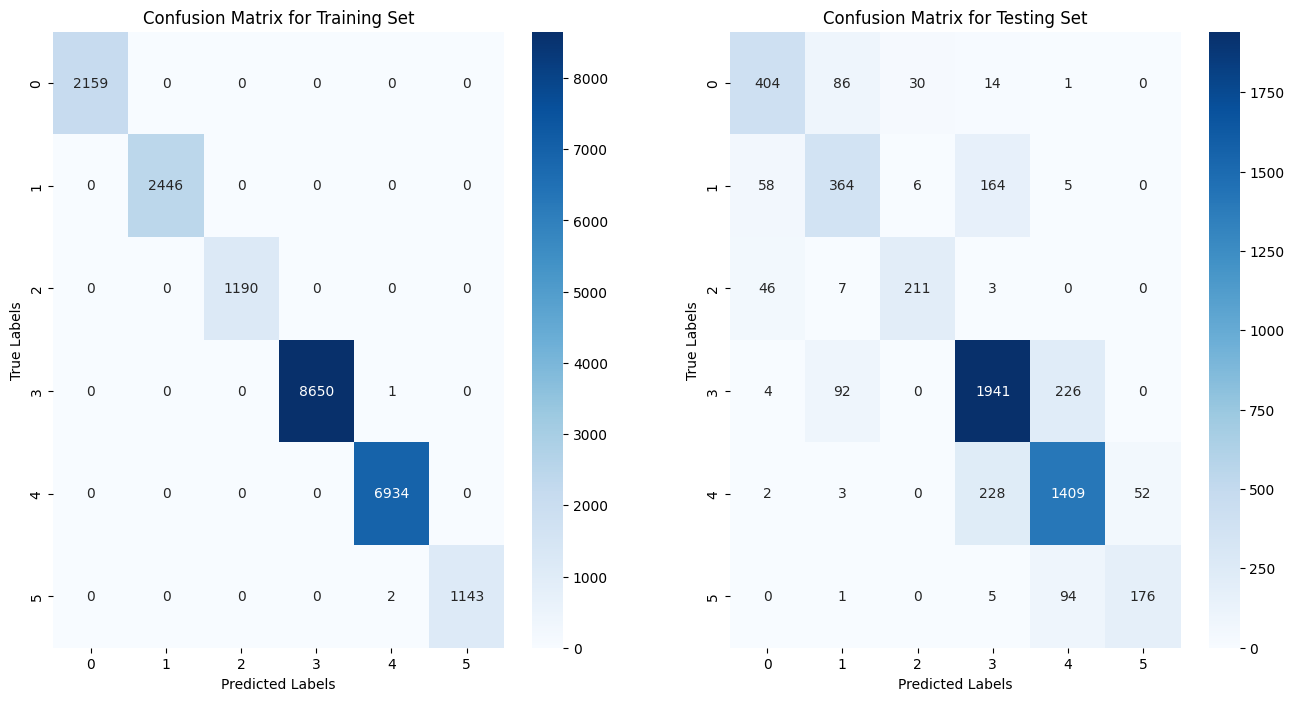

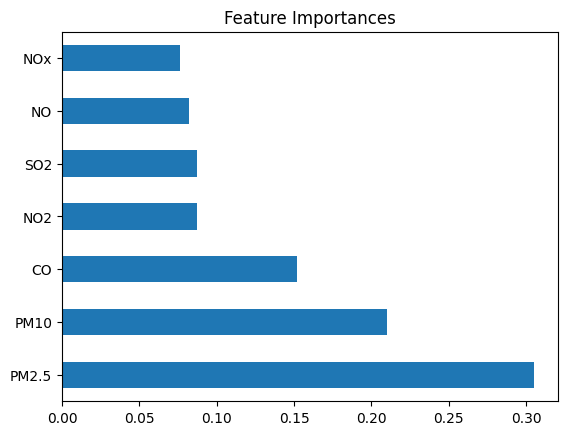

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, X_test, y_train, y_test are already defined

# Optional: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Predict on the training set
y_pred_train = rf_classifier.predict(X_train_scaled)

# Predict on the test set
y_pred_test = rf_classifier.predict(X_test_scaled)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training Metrics")
print(f'Accuracy: {accuracy_train}')
print(classification_report(y_train, y_pred_train))

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("\nTesting Metrics")
print(f'Accuracy: {accuracy_test}')
print(classification_report(y_test, y_pred_test))

# Confusion matrix for the test set
conf_mat_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Compute and plot confusion matrices
conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)
# Training Confusion Matrix
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix for Training Set')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Testing Confusion Matrix
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix for Testing Set')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()

# If you want to plot feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.show()


In [10]:
def predict_aqi_bucket(pm25, pm10, no, no2, nox, co, so2, rf_classifier, scaler):
    # Create a DataFrame from the input features
    input_features = pd.DataFrame({
        'PM2.5': [pm25],
        'PM10': [pm10],
        'NO': [no],
        'NO2': [no2],
        'NOx': [nox],
        'CO': [co],
        'SO2': [so2]
    })

    # Scale the features using the previously fitted scaler
    input_features_scaled = scaler.transform(input_features)

    # Predict the AQI bucket
    aqi_bucket = rf_classifier.predict(input_features_scaled)

    return aqi_bucket[0]

# Example usage:
# These values should be replaced with the actual input values you want to predict for
pm25_input = 158.36
pm10_input = 116.3
no_input = 2.3
no2_input = 21.39
nox_input = 23.31
co_input = 2.6
so2_input = 32.66

# Call the prediction function with the random forest classifier and the scaler from your model
predicted_bucket = predict_aqi_bucket(pm25_input, pm10_input, no_input, no2_input, nox_input, co_input, so2_input, rf_classifier, scaler)
print(f'The predicted AQI_Bucket is: {predicted_bucket}')

The predicted AQI_Bucket is: 2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [11]:
import pandas as pd

# Load the dataset
file_path = 'clean_air_hour.csv'  # Replace with your actual file path
data_hr = pd.read_csv(file_path)

# Function to find the best three Time_Of_Day with the least AQI_Bucket for a given day, month, and city
def find_best_times_of_day(data_hr, day, month, city_index):
    # Filter data for the given day, month, and city
    filtered_data = data_hr[(data_hr['Day'] == day) & (data_hr['Month'] == month) & (data_hr['City'] == city_index)]
    
    # Group by 'Times_Of_Day' and calculate the mean AQI for each time of day
    aqi_time_of_day = filtered_data.groupby('Times_Of_Day')['AQI'].mean().reset_index()
    
    # Sort the results to find the least mean AQI which indicates the least pollution
    best_times_of_day = aqi_time_of_day.sort_values(by='AQI').head(3)
    
    return best_times_of_day

# Input values for day, month, and city index
day = 25  # replace with your day
month = 3  # replace with your month
city = 1   # replace with your city index

# Perform the analysis
best_times = find_best_times_of_day(data_hr, day, month, city)

print(f"The top 3 Times_Of_Day with the least AQI on day {day}, month {month} for city index {city} are:")
print(best_times[['Times_Of_Day', 'AQI']].to_string(index=False))


The top 3 Times_Of_Day with the least AQI on day 25, month 3 for city index 1 are:
 Times_Of_Day       AQI
            1 90.000000
            0 91.090909
            2 91.500000


Training Accuracy: 0.6548113734778526
              precision    recall  f1-score   support

           0       0.56      0.60      0.58     25221
           1       0.54      0.46      0.49     58566
           2       0.67      0.76      0.71    197816
           3       0.60      0.54      0.57     51294
           4       0.69      0.68      0.68    160577
           5       0.74      0.48      0.58     32592

    accuracy                           0.65    526066
   macro avg       0.63      0.59      0.60    526066
weighted avg       0.65      0.65      0.65    526066

Testing Accuracy: 0.599892029167332
              precision    recall  f1-score   support

           0       0.50      0.55      0.52      6176
           1       0.45      0.38      0.42     14675
           2       0.63      0.71      0.67     49544
           3       0.54      0.48      0.51     12940
           4       0.64      0.63      0.63     40046
           5       0.63      0.42      0.50      8136

   

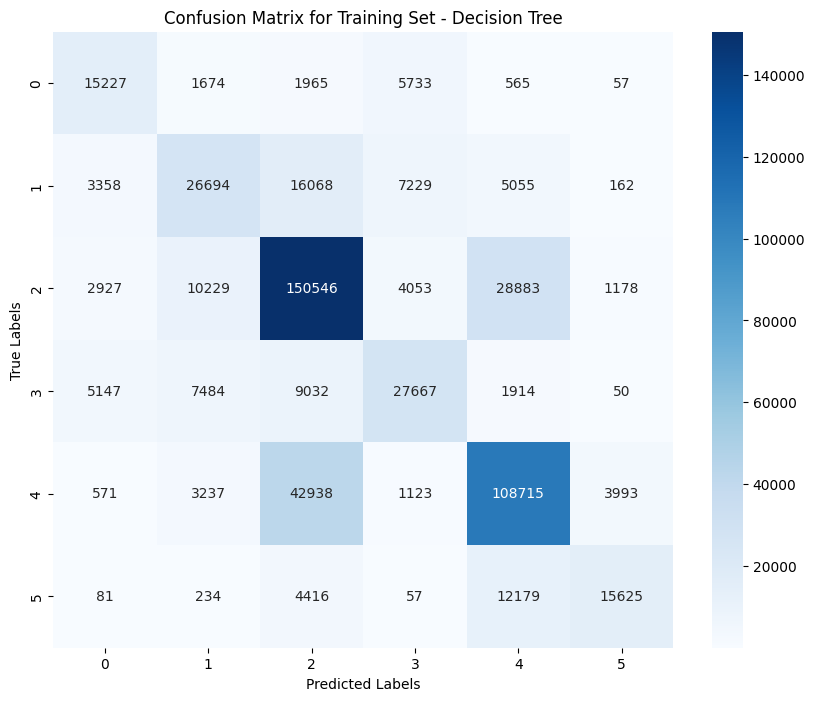

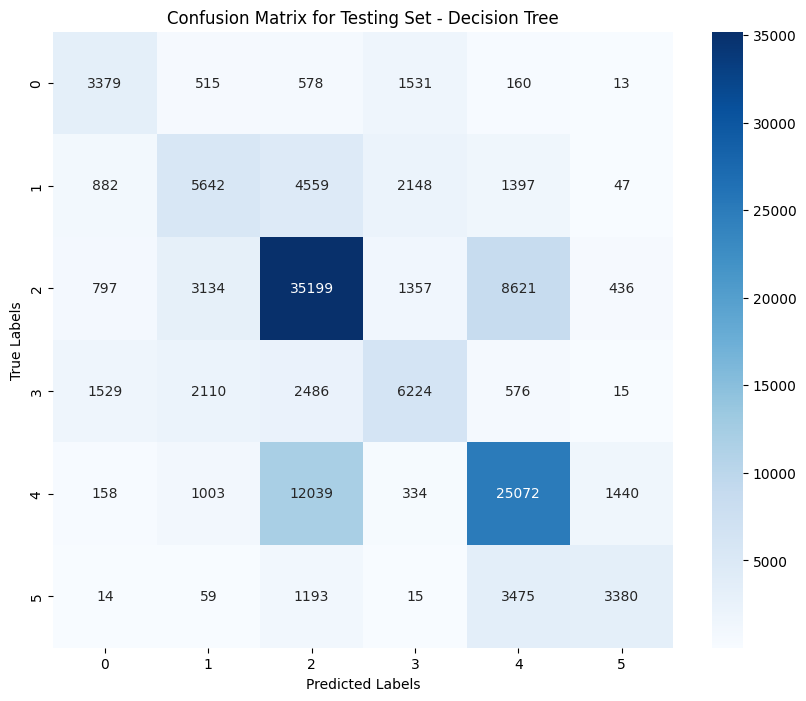

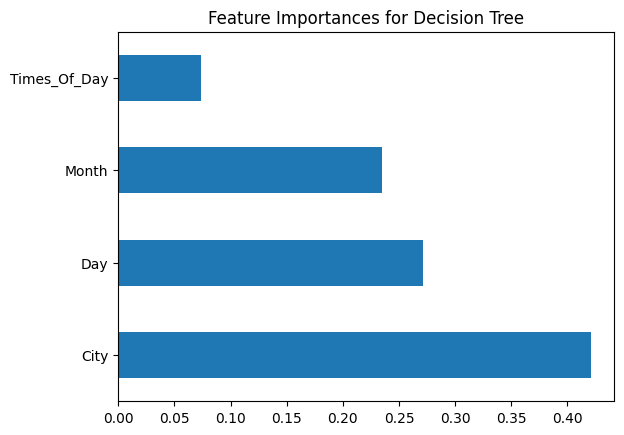

In [12]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'clean_air_hour.csv'  # Updated path for execution
data_hr = pd.read_csv(file_path)

# Preprocess the data
features = ['City', 'Month', 'Day', 'Times_Of_Day']
target = 'AQI_Bucket'

# Split the dataset
X_hr = data_hr[features]
y_hr = data_hr[target]
X_train_hr, X_test_hr, y_train_hr, y_test_hr = train_test_split(X_hr, y_hr, test_size=0.2, random_state=42)

# Optional: Scale the features
scaler = StandardScaler()
X_train_scaled_hr = scaler.fit_transform(X_train_hr)
X_test_scaled_hr = scaler.transform(X_test_hr)

# Train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled_hr, y_train_hr)

# Predict on the training set
y_pred_train = dt_classifier.predict(X_train_scaled_hr)

# Predict on the test set
y_pred_test = dt_classifier.predict(X_test_scaled_hr)

# Metrics for the training set
accuracy_train = accuracy_score(y_train_hr, y_pred_train)
print(f'Training Accuracy: {accuracy_train}')
print(classification_report(y_train_hr, y_pred_train))

# Metrics for the test set
accuracy_test = accuracy_score(y_test_hr, y_pred_test)
print(f'Testing Accuracy: {accuracy_test}')
print(classification_report(y_test_hr, y_pred_test))

# Confusion matrix for the training set
conf_mat_train = confusion_matrix(y_train_hr, y_pred_train)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Training Set - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion matrix for the test set
conf_mat_test = confusion_matrix(y_test_hr, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Testing Set - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Feature importance plot remains the same
feature_importances_dt = pd.Series(dt_classifier.feature_importances_, index=X_hr.columns)
feature_importances_dt.nlargest(10).plot(kind='barh')
plt.title('Feature Importances for Decision Tree')
plt.show()

In [13]:
import numpy as np

# Function to predict AQI_Bucket for all times_of_day given a city, month, and day
def predict_aqi_for_times_of_day(city, month, day, classifier, scaler):
    # Ensure that the 'City' feature is transformed appropriately if it's categorical
    # For now, this assumes 'City' is already encoded or is numeric
    
    # Create a DataFrame with all combinations for the given city, month, and day
    times_of_day = [0, 1, 2, 3, 4]
    data_to_predict = pd.DataFrame({
        'City': [city] * len(times_of_day),
        'Month': [month] * len(times_of_day),
        'Day': [day] * len(times_of_day),
        'Times_Of_Day': times_of_day
    })
    
    # Scale the features
    features_to_predict = scaler.transform(data_to_predict)
    
    # Make predictions
    predictions = dt_classifier.predict(features_to_predict)
    
    # Add predictions to the DataFrame
    data_to_predict['Predicted_AQI_Bucket'] = predictions
    
    # Return the DataFrame with predictions
    return data_to_predict

# Example usage
city_input = 2  # Replace with the actual city index or one-hot encoded vector
month_input = 1  # May
day_input = 5  # 15th day of the month

# Call the function with the classifier and scaler from your trained model
predicted_aqi = predict_aqi_for_times_of_day(city_input, month_input, day_input, dt_classifier, scaler)
print(predicted_aqi)


   City  Month  Day  Times_Of_Day  Predicted_AQI_Bucket
0     2      1    5             0                     3
1     2      1    5             1                     3
2     2      1    5             2                     1
3     2      1    5             3                     4
4     2      1    5             4                     4


In [14]:
import pickle
model_file_name = 'random_rorest_regressor_model_aqi.pickle'
# Open the file in binary write mode ('wb') to save the model
with open(model_file_name, 'wb') as file:
    pickle.dump(rf_regressor, file)
print(f"Model has been pickled and saved to {model_file_name}")

Model has been pickled and saved to random_rorest_regressor_model_aqi.pickle


In [15]:
model_file_name = 'decision_tree_classifier_model_time.pickle'
# Open the file in binary write mode ('wb') to save the model
with open(model_file_name, 'wb') as file:
    pickle.dump(dt_classifier, file)
print(f"Model has been pickled and saved to {model_file_name}")

Model has been pickled and saved to decision_tree_classifier_model_time.pickle


In [16]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
